In [35]:
import os
import cv2
import math
import json
import glob
import random
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from pprint import pprint 
from matplotlib import pyplot as plt


random.seed(0)
# num_classes = 100
# colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_classes)]

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

def transparent_overlays(image, annotation, alpha=0.5):
    img1 = image.copy()
    img2 = annotation.copy()

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    # img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    # dst = cv2.add(img1_bg, img2_fg)
    dst = cv2.addWeighted(image.copy(), 1-alpha, img2_fg, alpha, 0)
    img1[0:rows, 0:cols ] = dst
    return dst


num_classes = len(VOC_CLASSES)
colors = VOC_COLORMAP

In [3]:
df = pd.read_csv('../data/voc_train_data.csv')


## Get all pairs (using the actual labels not clustering or sequencing)

In [4]:
def intersectionAndUnion(imPred, imLab, numClass):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()
    imPred += 1
    imLab += 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab > 0)
    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))
    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)

def intersectionOverUnion(IU):
    # IoU = IU[0].sum() / IU[1].sum() # this is not good because the BG class is dominant
    classes_in_img = np.where(IU[1] != 0) # index of the classes that have pixels in the union value
    print(f"classes_in_img are {classes_in_img}\n\n")
    print(f"IoU is {IU[0][classes_in_img]/IU[1][classes_in_img]}\n\n")
    meanIoU = np.mean(IU[0][classes_in_img]/IU[1][classes_in_img])
    return meanIoU

def accuracy(preds, label):
    valid = (label >= 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (valid_sum + 1e-10)
    return acc, valid_sum

In [5]:
def color_im(img, colors):
    for i in range(len(colors)):
        img[:,:,0][np.where(img[:,:,0] == i)] = colors[i][0]
        img[:,:,1][np.where(img[:,:,1] == i)] = colors[i][1]
        img[:,:,2][np.where(img[:,:,2] == i)] = colors[i][2]
    return img

def vis_pair(img1, img2, label1, label2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    label1 = cv2.imread(label1)
    #print("uniq labels in l1; {}\n".format({i:VOC_CLASSES[i] for i in np.unique(label1)}))

    label2 = cv2.imread(label2)
    #print("uniq labels in l2; {}\n".format({i:VOC_CLASSES[i] for i in np.unique(label2)}))
    
    tmp_label2 = cv2.resize(label2, (int(label1.shape[1]), int(label1.shape[0])))
    
    label1[np.where(label1 == 0)] = 255 # to exclude the bg from intersection
    intersection = np.where(label1[:,:,0] == tmp_label2[:,:,0])[0].shape[0]
    #print(np.where(tmp_label2[:,:,0] != 0 )[0].shape)
    union = np.where(label1[:,:,0] != 255 )[0].shape[0] + np.where(tmp_label2[:,:,0] != 0 )[0].shape[0] - intersection
    
    #print("uniq labels in resized l2; {}\n".format({i:VOC_CLASSES[i] for i in np.unique(tmp_label2)}))

    ##plt.figure(figsize=(10, 7))
    ##plt.imshow(transparent_overlays(color_im(label1, colors), color_im(tmp_label2, colors), 0.45))
    ##plt.show()
    
    #IU = intersectionAndUnion(label1, tmp_label2, len(VOC_CLASSES))
    #print(f"IntersectionAndUnion is {IU}\n\n")
    #return intersectionOverUnion(IU)
    return intersection/union


 #### For each class look at all combinations of 2 (pairs) and calculate the iou of their labels (excluding the BG class)

In [9]:
output = ""
for i, c in enumerate(VOC_CLASSES):
    if c != 'background':
        #print(c)
        sub_data = df[df[c]==1]
        #print(f"numbers of image: {len(sub_data)} \n\n")
        count = 0
        for pair in itertools.combinations(sub_data['fpath_img'],2):
            row1 = df[df['fpath_img']==pair[0]]
            row2 = df[df['fpath_img']==pair[1]]
            imgs = [row1['fpath_img'].values[0],row2['fpath_img'].values[0]]
            segms = [row1['fpath_segm'].values[0],row2['fpath_segm'].values[0]]

            w, h =  row1['width'].values[0], row1['height'].values[0]

            iou = vis_pair(imgs[0], imgs[1], segms[0], segms[1])
            #if iou > 0.5 :
            new_line = {}
            new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line['iou'] = \
                    imgs, segms, int(w), int(h), iou
            #print(new_line)
            output += json.dumps(new_line) + "\n"

with open('../data/VOC_pairs_iou.odgt', 'w') as fp:
    fp.write(output)

In [36]:
df_pairs = pd.read_json('../data/VOC/VOC_pairs_iou.odgt', lines=True)

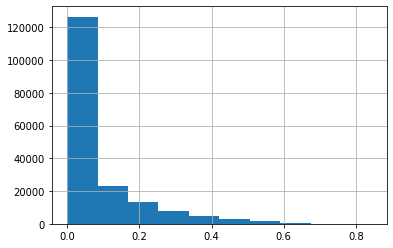

In [23]:
df_pairs['iou'].hist()


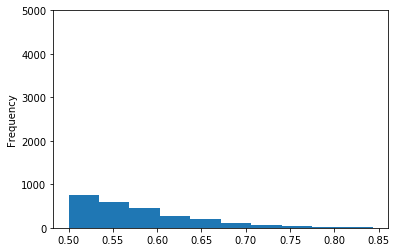

In [48]:
df_pairs[df_pairs['iou'] > 0.5]['iou'].plot.hist(ylim=(0,5000))

#### This analysis shows that in a dataset like VOC, the iou of the pairs of images representing the same class is actually very small. It would be interesting to do the same this for city scapes, plant dataset, ... It is likely that we get a different histogram for datasets that have evolving characteristics or evolving content 

In [40]:
df_pairs.head()

,fpath_img,fpath_segm,width,height,iou
0,[/data/sara/semantic-segmentation-pytorch/data...,[/data/sara/semantic-segmentation-pytorch/data...,281,500,0.246318
1,[/data/sara/semantic-segmentation-pytorch/data...,[/data/sara/semantic-segmentation-pytorch/data...,281,500,0.159835
2,[/data/sara/semantic-segmentation-pytorch/data...,[/data/sara/semantic-segmentation-pytorch/data...,281,500,0.062326
3,[/data/sara/semantic-segmentation-pytorch/data...,[/data/sara/semantic-segmentation-pytorch/data...,281,500,0.000000
4,[/data/sara/semantic-segmentation-pytorch/data...,[/data/sara/semantic-segmentation-pytorch/data...,281,500,0.123133


In [41]:
good_pairs = df_pairs[df_pairs['iou'] > 0.6]

In [44]:
good_pairs.to_json("../data/VOC/good_pairs.odgt", orient='records', lines=True)